<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Chicago West Nile Virus Prediction

### Contents:
#### Part 4 (of 4)
- Executive Summary
- Problem Statement
- Background & Research
- Data Wrangling
- Exploration & Visualisation
- Pre-Processing & Modelling
- Results & Analysis
- Kaggle Prediction
- [Cost-Benefit Analysis](#Cost-Benefit-Analysis)
- [Recommendations](#Recommendations)
- [Conclusions](#Conclusions)
- [References](#References)

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Cost-Benefit Analysis

As aforementioned in our EDA, we observed that the traps tested positive for WNV are scattered randomly. On closer inspection between spray dates in 2013 and number of mosquitoes tested positive for WNV, we found some evidence that spraying reduced the number of mosquitoes trapped. This in turn lowered the number of mosquitoes tested positive for WNV. Despite higher frequency of spraying in 2013, the number of mosquitoes tested positive for WNV is few times higher than 2011 across the same weeks. We believe there are two key explanations to this. One, pesticide spraying on adult mosquitoes has not been optimized in terms of locations and frequency. Two, confounding factors like weather conditions in 2013 accelerated the growth rate of mosquitoes, outweighing the effects of pesticide spraying. 

In the absence of data or study on effectiveness of pesticide spraying on incidence of human WNV case, we felt it would be meaningful to approach the cost-benefit analysis from a trade-off perspective. In other words, the number of human WNV cases that should have been avoided if we were to use our selected model to determine the pesticide coverage level.

We defined cost as the total expenditure associated with spraying pesticide on adult mosquitoes in incurred in a year. Without our classification model, a reasonable estimate coverage level would be the whole of Chicago, spanning an area of about 149,770 acres. Benefits will be measured by the cost avoidance or savings in the form of healthcare costs and productivity lost associated with the potential reduction in number of human WNV cases from spraying pesticide in Chicago.

### Method to project potential cost savings from reducing WNV hospitalized cases

With limited published data on the medical costs and economic burden for WNV, we will be referencing **Initial and Long-Term Costs of Patients Hospitalized with West Nile Virus Disease. American Journal of Tropical Medicine and Hygiene, 2014** to obtain historical cost estimates of hospitalized cases. These estimates will be used to compute potential cost savings from reducing hospitalization due to WNV disease. 

First, the paper estimated the direct and indirect medical costs of initial hospitalization and 5-year follow-up costs by WNV clinical syndrome, namely fever, meningitis, encephalitis, and acute flaccid paralysis (AFP), among a cohort of 80 hospitalized patients in Colorado in 2003. 38 of these patients were followed for 5 years to determine long-term medical and lost-productivity costs. Next, it predicted the total costs inccured by all hospitalized WNV cohort cases in the United States that were reported to CDC during the period of 1999-2012. Between 1999 and 2012, 37,088 WNV disease cases, including 16,196 (44%) neuroinvasive disease cases, were reported to CDC. Of these, 1,529 (4%) died and an estimated 18,313 (49%) of the total cases were hospitalized. The total costs was estimated by using Monte Carlo simulation of the findings from the cohort. Different cost components were adjusted to 2012 U.S. dollars (USD) using the prescription drugs part of the U.S. Consumer Price Index (CPI) for drug costs, the medical care part of CPI for medical costs, and the CPI productivity costs from the Bureau of Labor Statistics. Productivity tables from Grosse and others were used to derive the indirect (i.e., lost productivity) costs. Future costs were discounted at an annual rate of 3%, where appropriate. More details on the methodology, results and limitations of the study can be found in the following [link](https://www.ajtmh.org/view/journals/tpmd/90/3/article-p402.xml).

### Cost categories of hosptalized cases

In particular, we would like to draw your attention to the below table illustrating the total estimated costs for United States hospitalized West Nile virus cases and death from 1999 through 2012 by cost category from simulation. The mean and median represent the 10,000 outputs from the Monte Carlo simulation model for 18,256 hospitalized West Nile virus (WNV) disease cases.

|Cost Category|Description|Mean (USD)|Median (USD)|
|---|---|---|---|
|(A) Total acute medical care|Inpatient costs associated with hospital-based care|252,115,100|230,879,300|
|(B) Total acute lost productivity|Assumed for hospitalized patients who missed work had a work schedule of 5 out of every 7 days. Time lost from work, by age and sex, using estimates from Grosse and others. Does not include death.|22,081,260|16,144,050|
|(C) Total long-term medical care|Includes costs such as medical appointments and institutional care costs, drug costs and durable medical equipment incurred in the 5 years after initial hospitalization. |27,570,280|25,468,510|
|(D) Total long-term lost productivity|Similar to how (B) was estimated. For persons who retired early as a result of WNV, we valued their indirect costs as the number of potential years and months of lost employment(65 minus age at early retirement).|26,866,800|25,416,720|
|(E) Total lifetime lost productivity caused by deaths|Derived from the lifetime production value discounted at 3% for their age and sex.|449,464,800|449,464,800|
|(F) Grand total|Sum of (A) to (E)|778,098,240|747,373,380|

Lifetime lost productivity was calculated directly from Grosse and others based on age and sex for the 1,524 WNV disease case-patients reported to CDC who died.

### Deriving unit cost of different hospitalized cases

To derive the total costs for the below groups of patients, we will be using a few combinations of linear sum of the mean of the above cost categories.

* Hospitalized for fever, vomitting, rash and/or other minor symptoms: (A) + (B)
* Hospitalized for neuroinvasive disease (including encephalitis or meningitis or acute flaccid paralysis) and survived: (A) + (B) + (C) + (D)
* Hospitalized and died from neuroinvasive disease: (A) + (B) + (E) 

We will then divide by the number of cases and compound it with the inflation factor to obtain the present value of unit cost.

In [2]:
inflation_factor = 0.03 ## Assumed at 3% per annum
num_hospitalized = 18_256
num_neuroinvasive_disease = 16_196 
num_death = 1_524 
num_minor = num_hospitalized - num_neuroinvasive_disease

In [3]:
# Unit cost of a case hospitalized for fever and other minor symptoms
minor_unit_cost = (252_115_100 + 22_081_260) / 18_256 * (1 + inflation_factor) **4
print(f'On average, the present cost of a hospitalized case with minor symptoms is ${round(minor_unit_cost,2)}')

On average, the present cost of a hospitalized case with minor symptoms is $16904.6


In [4]:
# Unit cost of a case hospitalized for neuroinvasive disease and survived
major_unit_cost = ((252_115_100 + 22_081_260)/ 18_256 +
                   (27_570_280 + 26_866_800) / 16_196) * (1 + inflation_factor) ** 4
print(f'On average, the present cost of a hospitalized case with neuroinvasive disease and survived is ${round(major_unit_cost,2)}')

On average, the present cost of a hospitalized case with neuroinvasive disease and survived is $20687.6


In [5]:
# Unit cost of a hospitalized case and died from neuroinvasive disease
deceased_unit_cost = ((252_115_100 + 22_081_260)/ 18_256 +
                      (27_570_280 + 26_866_800) / 16_196 + 
                      449_464_800 / 1_524) *  (1 + inflation_factor) ** 4
print(f'On average, the present cost of a hospitalized case who died from neuroinvasive disease is ${round(deceased_unit_cost,2)}.')

On average, the present cost of a hospitalized case who died from neuroinvasive disease is $352627.62.


In [6]:
# Weighted average cost per hosptalized case
weighted_avg_cost = (num_minor / num_hospitalized * 16904.6 +
                     num_neuroinvasive_disease / num_hospitalized * 20687.6 +
                     num_death / num_hospitalized * 351542.14
)

print(f'The weighted average cost of a hospitalized case is ${round(weighted_avg_cost,2)}.')

The weighted average cost of a hospitalized case is $49607.26.


### Method to project potential cost savings from reducing WNV non-hospitalized cases

In the same paper, the authors cross referenced to another paper **Economic Cost Analysis of West
Nile Virus Outbreak, Sacramento County, California, USA, 2005** which estimated the average cost of non-hospitalized fever case at 1,170 USD. 

In [7]:
## Adjusting the average cost of a non-hospitalized fever case for inflation
non_hospitalized_unit_cost = 1_170 * (1 + inflation_factor) ** 10
print(f'On average, the present cost of a non-hospitalized fever case is ${round(non_hospitalized_unit_cost,2)}')

On average, the present cost of a non-hospitalized fever case is $1572.38


### Estimating cost of spraying 

The pesticide is sprayed by a truck-mounted fogger using very small amount of pesticide in a process known as Ultra Low Volume (ULV) fogging. The mist of microscopic droplets or "fog" is airborne and is not intended to leave significant residues. Flying mosquitoes are killed by contact with the fog. Mosquito spraying is usually done at night when most mosquitoes are flying and traffic is minimal. [(source)](https://www.chicago.gov/content/dam/city/depts/cdph/Mosquito-Borne-Diseases/Zenivex.pdf)

Fogging products are applied in Chicago at the rate of 1.5 fluid ounces (three
tablespoons) per acre. This ensures there is no significant risk to present to individuals and the community. [(source)](https://www.chicago.gov/content/dam/city/depts/cdph/Mosquito-Borne-Diseases/Zenivex.pdf) Zenivex E20 adulticide is an attractive option for professionals looking for advanced mosquito control. Assumed Zenivex E20 adulticide is used. 30 Gallons of Zenivex E20 costs 10,899.95 USD. [(source)](https://www.forestrydistributing.com/aqua-zenivex-e20-ulv-insecticide-zeocon).

We approximate the total costs to spray per acre of land in Chicago as follow:

In [8]:
## Convert 30 US liduid gallon to fluid ounces
gallon_to_ounce = 128
print(f'There are {gallon_to_ounce * 30} fluid ounces in 30 Gallons of Zenivex 20.')

There are 3840 fluid ounces in 30 Gallons of Zenivex 20.


In [9]:
# Compute cost of Zenivex 20 per acre
pesticide_cost_per_acre = 10899.95 / 3800 * 1.5
print(f'The cost of Zenivex 20 pesticide per acre is approximately {round(pesticide_cost_per_acre,2)}0 USD.')

The cost of Zenivex 20 pesticide per acre is approximately 4.30 USD.


In [10]:
# Given that the area of Chicago is about 150,000 acres
total_cost_pesticide = 150_000 * 4.30

In [11]:
# Assume labor and overhead costs are 50% of total_cost_pesticide
total_cost = 1.5 * total_cost_pesticide
total_cost

967500.0

Since the weighted average cost of a hospitalized case is at least 30 times higher than a non-hospitalized case, we shall focus on reducing hospitalized WNV case. We plot the graphs of total costs of spraying pesticide and the potential cost savings in the figure below. Guided by our classification model to conduct more targeted spraying, we assumed a 20% reduction in pesticide coverage,  bringing total costs down to $774,000.

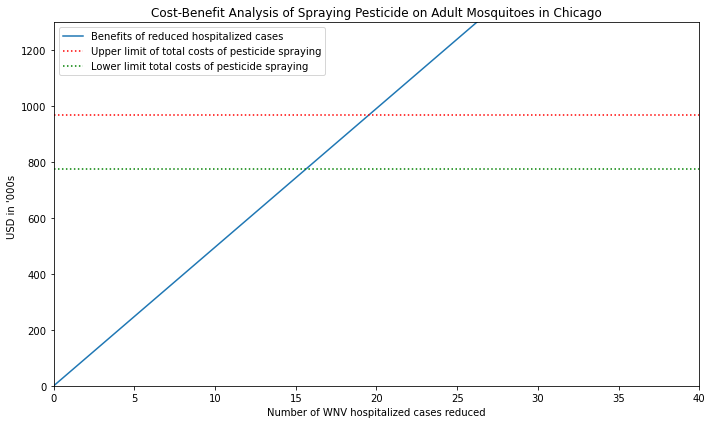

In [12]:
plt.figure(figsize=(10,6))

plt.title('Cost-Benefit Analysis of Spraying Pesticide on Adult Mosquitoes in Chicago')
plt.xlabel('Number of WNV hospitalized cases reduced')
plt.ylabel("USD in '000s ")

plt.plot(np.arange(0, 40),
         np.arange(0, 40) * 49607.26/1000, label = 'Benefits of reduced hospitalized cases')

# create horizontal line on the plot to illustrate the maximum cost of pesticide spraying
plt.axhline(y=total_cost/1000, color='r', linestyle=':', 
            label = 'Upper limit of total costs of pesticide spraying')
plt.axhline(y=total_cost/1000 * 0.8, color='g', linestyle=':', 
            label = 'Lower limit total costs of pesticide spraying')


plt.ylim(0,1300)
plt.xlim(0,40)
plt.legend()
plt.tight_layout()
plt.savefig('../plots/cost_benefit.png', dpi='figure', bbox_inches='tight', facecolor=(1, 1, 1))
plt.show();

#### Graphical analysis

The diagonal line in blue represents the benefits or cost savings from the number of WNV hospitalized cases reduced from spraying pesticide. The horizontal line in red represents the upper limit of the total estimated cost of spraying pesticide, that is without the help of our model. The horizontal  line in green represents the lower limit of the total estimated cost of spraying pesticide, that is more targeted spraying with the help of our model. The intersection point between the horizontal line mean benefits = costs. The benefit-cost ratio is 1. Any point along the diagonal line that is above the horizontal line implies that the benefit-cost ratio is greater than 1. In the absence of our model, the graph suggests that it will only be worthwhile to spray pesticide indiscriminately if we are confident that it will prevent 20 WNV hospitalized cases. With targeted spraying and hence lower total costs, the graph suggests that it will be worthwhile to spray pesticide if we are confident of that it will prevent 15 WNV hospitalized cases. Overall, the cost-benefit analysis seemed to show that spraying pesticide is highly cost effective.

## Recommendations

Reconciling findings from our EDA, selected model, and the above cost-benefit analysis, we strongly recommend IDPH to control mosquitoes population in Chicago by spraying pesticide in a more targeted fashion. First, IDPH should commence pesticide spraying from the start of July to the end of August, when higher average temperature accelerates growth of adult mosquito population. The recommended spraying frequency would be weekly for the pesticide to take effect. Second, repeated spraying can be performed on 'hot' zones in coordinates Groups 4, 16, 17, 18 and 23. Finally, it would be helpful to determine and target locations where majority of the Culex Pipiens and Culex Pipiens/Restuans populations are found.


In [13]:
## Visualization reference as backup

# Create data frame of annual number of WNV disease cases reported to CDC by Illonis 
# and annual number of WNV disease cases reported to CDC by Illonis 
# data = {'Year': [2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015],
#        'Num_WNV_cases': [884,54,60,252,215,101,20,5,61,34,290,117,44,77], 
#        'Num_neuroinvasive_disease_cases': [553,30,29,137,127,63,12,5,45,22,187,86,36,51]
#}


# illonois_data = pd.DataFrame(data)
# illonois_data.set_index('Year', inplace=True)

# plt.figure(figsize=(12,8))
# plt.plot(illonois_data['Num_WNV_cases'])
# plt.plot(illonois_data['Num_neuroinvasive_disease_cases'])
# plt.title('Number of West Nile Virus Cases and WNV neuroinvasive disease reported to CDC in Illonois')
# plt.xlabel('Year')
# plt.ylabel('Number of cases')
# plt.savefig('Num_WNV_cases_Illonois')

## Conclusions

The best performing model for classifying whether WNV is present for the imbalanced dataset is the optimized logistic regression model. It has an accuracy score of 0.657, recall score of 0.818, and AUC score of 0.790 on the partitioned test dataset. In other words, the model was able to correctly predict 81.8% of positive cases. The results from the model can give us a good prediction of the areas that have a higher presence of WNV. With this information, we can target the spraying of pesticide at these high-risk areas more regularly to control the mosquito population and reduce the presence of WNV.
 
At the same time, we can make improvements to the model by performing over-sampling on the minority class (positive cases) in the dataset. This would increase the number of positive WNV cases to balance the distribution of positive and negative classes. This dataset can then be used to train a new logistic regression model that could correctly predict more positive cases.
 
All, if not most types of mosquitoes, share a similar life cycle. Most mosquito control methods focus on the larval stages because they limit mosquito populations from the start. Spraying pesticide on mosquitoes is only one of the many possible control measures. However, they require repeated applications, have potential negative ecological repercussions, and pose a health risk to the human population. Alternatively, the use of minnows, which are small freshwater fishes, to control mosquito populations may provide many purported benefits in the form of its low maintenance, cost effectiveness, environmental friendliness, and minimal implications on public health.
 
It cannot be over-emphasized that mosquito control requires a concerted effort from individuals, the community, and the government. Relying on one control method alone is also likely to be insufficient in curbing the spread of WNV. A multi-pronged approach, with the participation and support of all stakeholders, is what is needed to keep the WNV at bay.
 
Future steps of this project would entail factoring in the benefit derived (in terms of the cost saved) not just from reducing cases of WNV but also other forms of mosquito-borne diseases such as Zika, Chikungunya, dengue, and malaria. It would also be interesting to analyse the cost-benefit of employing other forms of mosquito eradication measures aside from pesticide spraying, such as the aforementioned use of minnows. Lastly, the predictive model can be modified and applied to help predict and direct spray efforts in other cities of the USA.

## References

[1] https://science.sciencemag.org/content/286/5448/2333.abstract <br>
[2] https://www.cdc.gov/westnile/index.html?CDC_AA_refVal=https%3A%2F%2Fwww.cdc.gov%2Fwestnile%2Ffaq%2FgenQuestions.html <br>
[3] https://www.ajtmh.org/view/journals/tpmd/90/3/article-p402.xml <br>
[4] https://www.epa.gov/climate-indicators/climate-change-indicators-west-nile-virus <br>
[5] https://www.chicago.gov/content/dam/city/depts/cdph/Mosquito-Borne-Diseases/Zenivex.pdf <br>
[6] https://www.forestrydistributing.com/aqua-zenivex-e20-ulv-insecticide-zeocon